# Analyze A/B Test Results 

This project will assure you have mastered the subjects covered in the statistics lessons. We have organized the current notebook into the following sections: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)



<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.


<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [331]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

### ToDo 1.1
Now, read in the `ab_data.csv` data. Store it in `df`. Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>




**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [332]:
#reading the data 
df= pd.read_csv('ab_data.csv')
# display the first 5 rows
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Use the cell below to find the number of rows in the dataset.

In [333]:
# number of rows and columns
df.shape

(294478, 5)

**c.** The number of unique users in the dataset.

In [334]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

**d.** The proportion of users converted.

In [335]:
# proportion of users converted
df.query('converted == 1').user_id.nunique()/ df['user_id'].nunique()

0.12104245244060237

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [336]:
# the number of times where the wrong page showed to the users of treatment group 
treatment_opage = df.query('group == "treatment" and landing_page == "old_page"').user_id.count()
treatment_opage

1965

In [337]:
# the number of times where the wrong page showed to the users of control group
control_npage = df.query("group == 'control' and landing_page == 'new_page'").user_id.count()
control_npage

1928

In [338]:
# total missmatch pages
plus= treatment_opage + control_npage
plus

3893

**f.** Do any of the rows have missing values?

In [339]:
df.isnull().sum() # no missing values

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

### ToDo 1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  


Use **Quiz 2** in the classroom to figure out how should we handle the rows where the group and landing_page columns don't match?

**a.** Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [340]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
dfi = df.drop(df.query("group == 'control' and landing_page == 'new_page'").index)
df2 = dfi.drop(df.query('group == "treatment" and landing_page == "old_page"').index)

In [341]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### ToDo 1.3  
Use **df2** and the cells below to answer questions for **Quiz 3** in the classroom.

**a.** How many unique **user_id**s are in **df2**?

In [342]:
#number of uniue user_id
df2['user_id'].nunique()

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [343]:
# one user_id repeated
df2['user_id'].duplicated().sum()

1

In [344]:
# the repeated user_id
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**c.** Display the rows for the duplicate **user_id**? 

In [345]:
# Displaying the rows for the user_id 773192
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [346]:
# Remove one of the rows with a duplicate user_id.
df2 = df2.drop(df2[(df2.user_id == 773192) & (df2['timestamp'] == '2017-01-09 05:37:58.781806')].index)

In [347]:
# Check again if the row with a duplicate user_id is deleted or not
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


### ToDo 1.4  
Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>





In [348]:
# the probability of an individual converting regardless of the page
df2.converted.mean()

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [349]:
# the probability of an individual in the control group converting
control_convert = df2.query('group == "control"')['converted'].mean()
control_convert

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [350]:
# the probability of an individual in the treatment group converting
treatment_convert = df2.query('group == "treatment"')['converted'].mean()
treatment_convert

0.11880806551510564

In [351]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = treatment_convert - control_convert
obs_diff

-0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [352]:
# the probability of a user receiving new page
df2[df2['landing_page']=='new_page'].user_id.count() / df2.user_id.count()

0.5000619442226688

**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

>**the probaility of users in control group converting is 12.04 %
and the probabilty of users in the treatment group converting is 11.88% 
so they are very colse and the treatment gruop that was shown the new page didn't lead more conversions 
.**

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### ToDo 2.1
For now, consider you need to make the decision just based on all the data provided.  

> Recall that you just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page (ToDo 1.4.c). 

If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

> **$H_0$**:  **$p_{old}$** - **$p_{new}$** >= 0\
>**$H_1$** : **$p_{old}$** - **$p_{new}$** < 0 

### ToDo 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, you will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 



Use the cells below to provide the necessary parts of this simulation.  You can use **Quiz 5** in the classroom to make sure you are on the right track.

**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [353]:
# under the Null hypothesis p_new = p_population
p_new = df2.converted.mean()
p_new

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [354]:
# under the Null hypothesis p_old = p_population
p_old = df2.converted.mean()
p_old

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>
*Hint*: The treatment group users are shown the new page.

In [355]:
# n_new of individuals int the treatment gruop
n_new = df2.query('group == "treatment"')['user_id'].nunique()
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [356]:
# n_old of individuals int the control gruop
n_old = df2.query('group == "control"')['user_id'].nunique()
n_old

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>
*Hint*: Use `numpy.random.choice()` method to randomly generate $n_{new}$ number of values. <br>
Store these $n_{new}$ 1's and 0's in the `new_page_converted` numpy array.


In [357]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([0 , 1], size=n_new, p=[p_new ,1-p_new])
new_page_converted

array([1, 1, 0, ..., 1, 1, 0])

In [358]:
#the mean out come for the new_converted page
new_page_converted_mean = np.random.choice([0, 1], size=n_new, p=[ p_new,1-p_new]).mean()
new_page_converted_mean

0.881061179547175

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [359]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([0, 1], size=n_old, p=[p_old ,1-p_old])
old_page_converted

array([1, 1, 1, ..., 1, 1, 1])

In [360]:
#the mean out come for the old_converted page
old_page_converted_mean = np.random.choice([0, 1], size=n_old, p=[p_old ,1-p_old]).mean()
old_page_converted_mean

0.8816168068615169

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [361]:
converted_diff =  new_page_converted_mean - old_page_converted_mean
converted_diff

-0.0005556273143418888


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [363]:
# simulating the 10000 trials
new_page_converted = np.random.binomial(n_new, p_new, 10000)/n_new
old_page_converted = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_page_converted - old_page_converted 

In [364]:
# Convert to numpy array
p_diffs = np.array(p_diffs)

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.<br><br>

Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  


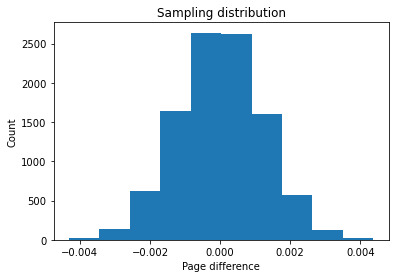

In [365]:
# Plot sampling distribution
plt.hist(p_diffs);
plt.title('Sampling distribution')
plt.xlabel('Page difference') 
plt.ylabel('Count'); 

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [366]:
# calculating the actual difference observed in the df2 data
control_df = df2.query('group == "control"')
control_ctr = control_df['converted'].mean()

control_ctr

0.1203863045004612

In [367]:
# calculating the actual difference observed in the df2 data
treatment_df = df2.query('group == "treatment"')
treatment_ctr = treatment_df['converted'].mean()

treatment_ctr

0.11880806551510564

In [368]:
# the actual difference observed in the df2 data
obs_diffe = treatment_ctr - control_ctr
obs_diffe

-0.0015782389853555567

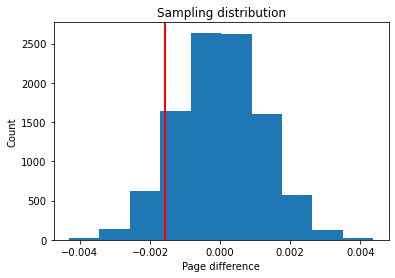

In [369]:
# Plot sampling distribution
plt.hist(p_diffs);
plt.axvline(obs_diff,color='r', linewidth=2)
plt.title('Sampling distribution') 
plt.xlabel('Page difference')  
plt.ylabel('Count');  

In [370]:
# p-value
(p_diffs > obs_diff).mean()

0.905

**k.** Please explain in words what you have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? *Hint*: Compare the value above with the "Type I error rate (0.05)". 

>**The value we Calculate called P-value , since the p-value is more than our type 1 error rate .05 we fail to reject the Null hypothesis which means that the old page is the same or better than the new page**



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [371]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query('landing_page == "old_page"')['converted'].sum()

# number of conversions with the new_page
convert_new = df2.query('landing_page == "new_page"')['converted'].sum()

# number of individuals who were shown the old_page
n_old = df2.query('landing_page == "old_page"')['user_id'].count()

# number of individuals who received new_page
n_new = df2.query('landing_page == "new_page"')['user_id'].count()
n_new, n_old, convert_new, convert_old 

(145310, 145274, 17264, 17489)

**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 
>**Hint**: <br>
It's a two-tailed if you defined $H_1$ as $(p_{new} = p_{old})$. <br>
It's a left-tailed if you defined $H_1$ as $(p_{new} < p_{old})$. <br>
It's a right-tailed if you defined $H_1$ as $(p_{new} > p_{old})$. 

The built-in function above will return the z_score, p_value. 

---
### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. We determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. In other words, a "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.



In [372]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old],[n_new, n_old],alternative='larger')
print(z_score, p_value)

-1.3109241984234394 0.9050583127590245


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>


>**our hypothesis is a right-tailed and $Z_{score}$ < $Z_{\alpha}$ , p-value is more than .05 so we fail to reject null hypothesis and the z test results agree with the findings in part j and k**

<a id='regression'></a>
### Part III - A regression approach

### ToDo 3.1 
In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

>**Logistic Regression.**

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [373]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df['group'])['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [374]:
# fitting my model
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [375]:
# Regression Results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 20 Apr 2022   Pseudo R-squ.:               8.077e-06
Time:                        20:56:22   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  


>**The P-value is 0.190\
The hypothesis for this model is\
$H_0$**:  **$p_{old}$** - **$p_{new}$** = 0\
>**$H_1$** : **$p_{old}$** - **$p_{new}$** != 0 \
>**The hypothesis in Part III is a two sided while the one in part II is one sided\
the p-value is still greater than the type I error so we fial to reject the null hypothesis**

**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

>**Adding a relevant factors may influence the conversions and can prevent bias in the estimate of the other regression coefficient, Adding irrelevant factors can increase the variance of the estimate of other correlation coefficient and will not have any benefits .**

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 
 

In [376]:
# Read the countries.csv
countries_df = pd.read_csv('countries.csv')
countries_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [377]:
# Join with the df2 dataframe
df_merged = df2.set_index('user_id').join(countries_df.set_index('user_id'))
df_merged.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country
user_id,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [378]:
# Create the necessary dummy variables
df_merged[['US','CA', 'UK']] = pd.get_dummies(df_merged['country'])
df_merged = df_merged.drop('CA', axis=1)

In [379]:
# fitting my model
log_mod = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'UK', 'US']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 20 Apr 2022   Pseudo R-squ.:               2.323e-05
Time:                        20:56:40   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9794      0.013   -155.415      0.000      -2.004      -1.954
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK            -0.0099      0.013     -0.743      0.457      -0.036       0.016
US            -0.0506      0.028     -1.784      0.074      -0.106       0.005
==============================================================================
"""

>**the p-value is greater than tybe I error so we fail to reject the null hypothesis the country has a no significant impact on conversion.**

**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


In [380]:
# Create the necessary additional columns
df_merged["US_page"] = df_merged["ab_page"] * df_merged["US"]
df_merged["UK_page"] = df_merged["ab_page"] * df_merged["UK"]

In [381]:
# Fit your model, and summarize the results
logit_mod = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'US', 'UK', 'US_page', 'UK_page']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Wed, 20 Apr 2022   Pseudo R-squ.:               3.482e-05
Time:                        20:56:44   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9922      0.016   -123.457      0.000      -2.024      -1.961
ab_page        0.0108      0.023      0.475      0.635      -0.034       0.056
US            -0.0118      0.040     -0.296      0.767      -0.090       0.066
UK             0.0057      0.019      0.306      0.760      -0.031       0.043
US_page       -0.0783      0.057     -1.378      0.168      -0.190       0.033
UK_page       -0.0314      0.027     -1.181      0.238      -0.084       0.021
==============================================================================
"""

>**The p-value is still greater than tybe I error so again we fail to reject the null hypothesis**

>**I believe that we should keep using the old page, we do not have enough evidence to reject the null hypothesis based on the previous analysis in all of them we failed to reject the Null hypothesis, we don't need the new page since the old page performance as well as the new page or better.**